# 内容
- データ読み込み
- split
- x, y生成
- 学習
- 評価
- submit

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

import utils as ut

## 準備

In [2]:
DEBUG = True
ut.seed_everything(24)

In [3]:
tr_file = "../../input/ventilator-pressure-prediction/train.csv"
ts_file = "../../input/ventilator-pressure-prediction/test.csv"
tr_df = pd.read_csv(tr_file)
ts_df = pd.read_csv(ts_file)

In [4]:
# shuffled breath_id
tr_df["shuffled_breath_id"] = ut.make_shuffled_id(tr_df["breath_id"])

## 学習

In [5]:
def make_x(df):
    ft = ut.Feature()
    x = ft.transform(df)
    return x

def make_y(df):
    tg = ut.Target()
    y = tg.transform(df)
    return y

def get_model(n_feat, prefix=""):
    model_prms = {
        "scaling_prms": dict(n_scaler=n_feat),
        "dnn_prms": dict(n_feat=n_feat, n_channel=256, dropout=0.0, n_rc_layer=4), 
        "tr_prms": dict(
            criterion=ut.VentilatorLoss(),
            opt="adamw",
            opt_params=dict(lr=0.001, weight_decay=1e-6),
            sch_params=None, #{'max_lr': lr, 'pct_start':0.1, 'div_factor':5, 'final_div_factor': 10000}, # initial_lr = max_lr/div_factor, min_lr = initial_lr/final_div_factor
            epochs=20, 
            prefix=prefix,
            save_best=True,
            maximize_score=False,
        ), 
        "seq_len": 80,
        "use_seq_len": 40, 
        "train_batch_size": 256,
        "pred_batch_size": 1024,
    }
    model = ut.Model(**model_prms)
    return model

def run_fold(tr_df, vl_df, prefix=""):
    # x, y
    tr_x = make_x(tr_df)
    tr_y = make_y(tr_df)
    vl_x = make_x(vl_df)
    vl_y = make_y(vl_df)

    model = get_model(tr_x.shape[1], prefix)
    model.fit(tr_x, tr_y, vl_x, vl_y)

    #tr_pred = model.predict(tr_x)
    vl_pred = model.predict(vl_x)

    #tr_df = pd.concat([tr_df, tr_x, pd.DataFrame(tr_pred, index=tr_df.index, columns=["pred"])], axis=1)
    vl_df = pd.concat([vl_df, vl_x, pd.DataFrame(vl_pred, index=vl_df.index, columns=["pred"])], axis=1)
    return model, tr_df, vl_df

def run_cv(df, n_split, n_fold):
    kf = model_selection.GroupKFold(n_splits=n_split)

    oof_df = []
    for fold, (tr_idxs, vl_idxs) in enumerate(kf.split(X=np.arange(len(df)), groups=df["shuffled_breath_id"].values)):
        if n_fold <= fold:
            break
        print("fold", fold)
        prefix = f"fold{fold}_"

        tr_df = df.iloc[tr_idxs].copy()
        vl_df = df.iloc[vl_idxs].copy()
        tr_df["fold"] = fold
        vl_df["fold"] = fold

        model, tr_df, vl_df = run_fold(tr_df, vl_df, prefix)

        oof_df.append(vl_df)
        with open(f'{prefix}model.pickle', mode='wb') as fp:
            model.set_dev('cpu')
            pickle.dump(model, fp)

        #tr_df.to_csv(f"{prefix}tr_df.csv", index=False)
        #vl_df.to_csv(f"{prefix}vl_df.csv", index=False)
    oof_df = pd.concat(oof_df, axis=0)

    return oof_df

In [6]:
n_split = 2
n_fold = 1
oof_df = run_cv(tr_df, n_split, n_fold)
oof_df.to_csv("oof.csv")

fold 0


  0%|          | 0/147 [00:00<?, ?it/s]


epoch  0
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.3474 | Score: 0.34736
{'loss': 0.34736503660678864, 'score': 0.34736496, 'mae': 0.34736496}
Valid Loss: 0.2179 | Score: 0.21793
{'loss': 0.21790510416030884, 'score': 0.21793437, 'mae': 0.21793437}
Update best score : 0.21793437
Save model : fold0_model.pth

epoch  1
lr  0.001


  1%|▏         | 2/147 [00:00<00:09, 14.64it/s]


Train Loss: 0.1892 | Score: 0.18922
{'loss': 0.18922014798031372, 'score': 0.18922018, 'mae': 0.18922018}
Valid Loss: 0.1665 | Score: 0.16652
{'loss': 0.16650369159273198, 'score': 0.16651691, 'mae': 0.16651691}
Update best score : 0.16651691
Save model : fold0_model.pth

epoch  2
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 14.12it/s]


Train Loss: 0.1562 | Score: 0.15623
{'loss': 0.15623253269665907, 'score': 0.1562325, 'mae': 0.1562325}
Valid Loss: 0.1342 | Score: 0.13424
{'loss': 0.13423006840654322, 'score': 0.13424069, 'mae': 0.13424069}
Update best score : 0.13424069
Save model : fold0_model.pth

epoch  3
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 14.12it/s]


Train Loss: 0.1379 | Score: 0.13788
{'loss': 0.13787556388953917, 'score': 0.13787556, 'mae': 0.13787556}
Valid Loss: 0.1303 | Score: 0.13035
{'loss': 0.1303247314047169, 'score': 0.13034897, 'mae': 0.13034897}
Update best score : 0.13034897
Save model : fold0_model.pth

epoch  4
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 14.32it/s]


Train Loss: 0.1172 | Score: 0.11718
{'loss': 0.11718221566304057, 'score': 0.11718222, 'mae': 0.11718222}
Valid Loss: 0.1236 | Score: 0.12361
{'loss': 0.1235957351085302, 'score': 0.12360665, 'mae': 0.12360665}
Update best score : 0.12360665
Save model : fold0_model.pth

epoch  5
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 13.55it/s]


Train Loss: 0.1087 | Score: 0.10865
{'loss': 0.10865363757423803, 'score': 0.10865364, 'mae': 0.10865364}
Valid Loss: 0.0980 | Score: 0.09804
{'loss': 0.09803181645032522, 'score': 0.09803949, 'mae': 0.09803949}
Update best score : 0.09803949
Save model : fold0_model.pth

epoch  6
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 13.64it/s]


Train Loss: 0.1024 | Score: 0.10244
{'loss': 0.10244179709630759, 'score': 0.10244183, 'mae': 0.10244183}
Valid Loss: 0.0990 | Score: 0.09899
{'loss': 0.09898359751379168, 'score': 0.098994054, 'mae': 0.098994054}

epoch  7
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 14.09it/s]


Train Loss: 0.0969 | Score: 0.09693
{'loss': 0.09692920273055836, 'score': 0.09692921, 'mae': 0.09692921}
Valid Loss: 0.0944 | Score: 0.09443
{'loss': 0.09442141450740196, 'score': 0.09442678, 'mae': 0.09442678}
Update best score : 0.09442678
Save model : fold0_model.pth

epoch  8
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0945 | Score: 0.09446
{'loss': 0.0944596946138103, 'score': 0.0944597, 'mae': 0.0944597}
Valid Loss: 0.0897 | Score: 0.08971
{'loss': 0.08969513085242864, 'score': 0.08970605, 'mae': 0.08970605}
Update best score : 0.08970605
Save model : fold0_model.pth

epoch  9
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0879 | Score: 0.08794
{'loss': 0.08794338327078592, 'score': 0.087943405, 'mae': 0.087943405}
Valid Loss: 0.0841 | Score: 0.08412
{'loss': 0.08411382239412617, 'score': 0.084115446, 'mae': 0.084115446}
Update best score : 0.084115446
Save model : fold0_model.pth

epoch  10
lr  0.001


  1%|▏         | 2/147 [00:00<00:11, 12.38it/s]


Train Loss: 0.0869 | Score: 0.08691
{'loss': 0.08691012322091732, 'score': 0.08691012, 'mae': 0.08691012}
Valid Loss: 0.0949 | Score: 0.09493
{'loss': 0.0949278236240954, 'score': 0.09493283, 'mae': 0.09493283}

epoch  11
lr  0.001


  1%|▏         | 2/147 [00:00<00:11, 12.97it/s]


Train Loss: 0.0830 | Score: 0.08301
{'loss': 0.08301411320765813, 'score': 0.08301413, 'mae': 0.08301413}
Valid Loss: 0.0877 | Score: 0.08773
{'loss': 0.08771707218241047, 'score': 0.087727144, 'mae': 0.087727144}

epoch  12
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0802 | Score: 0.08021
{'loss': 0.0802138730579493, 'score': 0.08021386, 'mae': 0.08021386}
Valid Loss: 0.0788 | Score: 0.07883
{'loss': 0.07882910725232717, 'score': 0.07883142, 'mae': 0.07883142}
Update best score : 0.07883142
Save model : fold0_model.pth

epoch  13
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0793 | Score: 0.07930
{'loss': 0.0792957860596326, 'score': 0.079295784, 'mae': 0.079295784}
Valid Loss: 0.0779 | Score: 0.07792
{'loss': 0.07791370072880306, 'score': 0.077924006, 'mae': 0.077924006}
Update best score : 0.077924006
Save model : fold0_model.pth

epoch  14
lr  0.001


  1%|▏         | 2/147 [00:00<00:11, 12.46it/s]


Train Loss: 0.0763 | Score: 0.07635
{'loss': 0.07634997362790465, 'score': 0.07634996, 'mae': 0.07634996}
Valid Loss: 0.0853 | Score: 0.08529
{'loss': 0.08528829225011773, 'score': 0.08529147, 'mae': 0.08529147}

epoch  15
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0769 | Score: 0.07688
{'loss': 0.07687934787094998, 'score': 0.07687933, 'mae': 0.07687933}
Valid Loss: 0.0717 | Score: 0.07173
{'loss': 0.07171255269566097, 'score': 0.07172743, 'mae': 0.07172743}
Update best score : 0.07172743
Save model : fold0_model.pth

epoch  16
lr  0.001


  1%|▏         | 2/147 [00:00<00:11, 13.02it/s]


Train Loss: 0.0720 | Score: 0.07204
{'loss': 0.07204026371544721, 'score': 0.072040275, 'mae': 0.072040275}
Valid Loss: 0.0723 | Score: 0.07233
{'loss': 0.07232578843832016, 'score': 0.07233314, 'mae': 0.07233314}

epoch  17
lr  0.001


  1%|▏         | 2/147 [00:00<00:11, 12.53it/s]


Train Loss: 0.0692 | Score: 0.06920
{'loss': 0.06920108966985528, 'score': 0.06920112, 'mae': 0.06920112}
Valid Loss: 0.0759 | Score: 0.07593
{'loss': 0.07592304755707045, 'score': 0.075934954, 'mae': 0.075934954}

epoch  18
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0703 | Score: 0.07025
{'loss': 0.07025257011457366, 'score': 0.07025259, 'mae': 0.07025259}
Valid Loss: 0.0707 | Score: 0.07072
{'loss': 0.07071110908244108, 'score': 0.07072154, 'mae': 0.07072154}
Update best score : 0.07072154
Save model : fold0_model.pth

epoch  19
lr  0.001


100%|██████████| 37/37 [00:03<00:00, 11.31it/s]



Train Loss: 0.0688 | Score: 0.06884
{'loss': 0.06883546378032691, 'score': 0.06883546, 'mae': 0.06883546}
Valid Loss: 0.0680 | Score: 0.06805
{'loss': 0.06804038846009486, 'score': 0.06804847, 'mae': 0.06804847}
Update best score : 0.06804847
Save model : fold0_model.pth


100%|██████████| 37/37 [00:02<00:00, 13.55it/s]


## 評価

In [7]:
ev = ut.Evaluation(oof_df)

In [8]:
score = ev.calc_scores()
print(score)

{0: {'mae': 0.5413944219352819}, 'av': {'mae': 0.5413944219352819}}


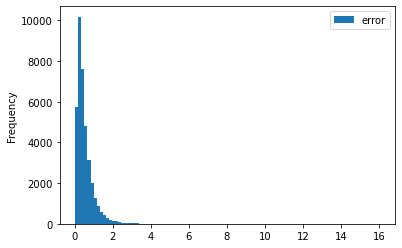

In [9]:
breath_mae = ev.calc_breath_mae()
breath_mae = breath_mae.sort_values("error", ascending=False)
breath_mae.plot.hist(bins=100)
plt.show()

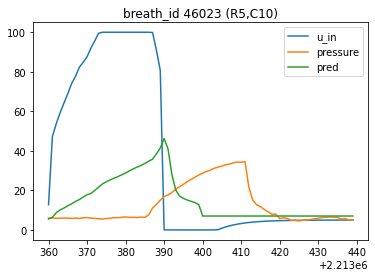

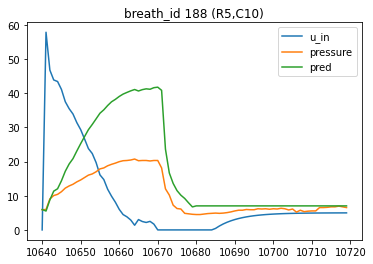

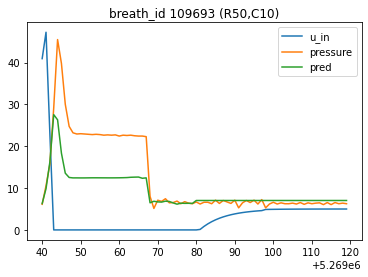

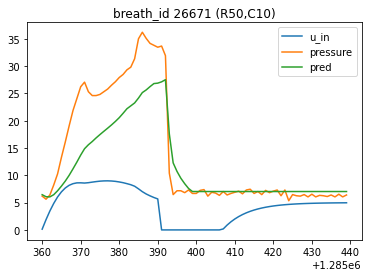

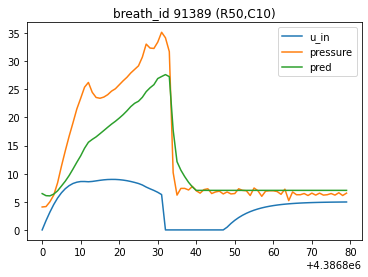

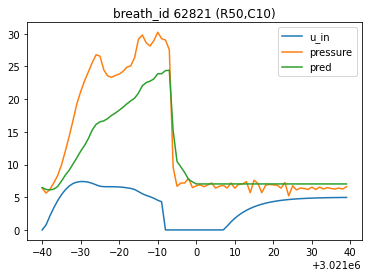

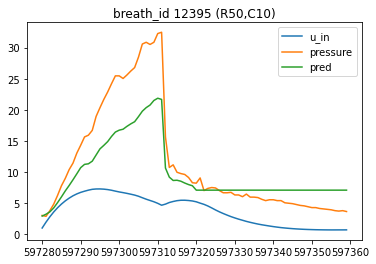

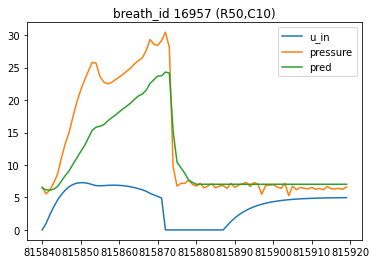

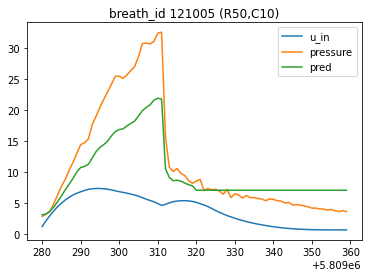

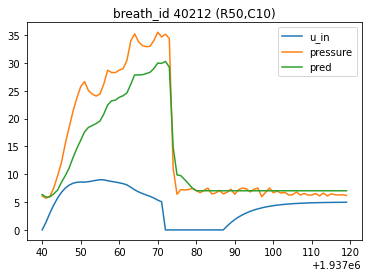

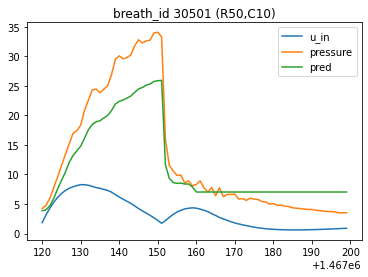

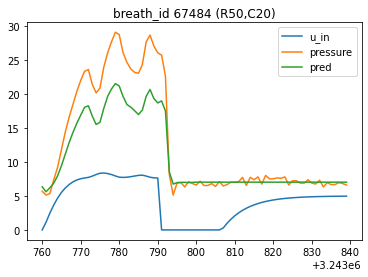

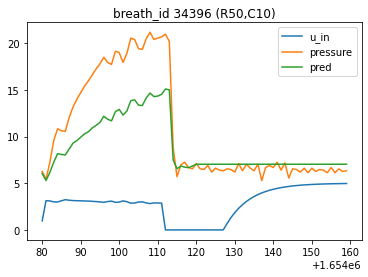

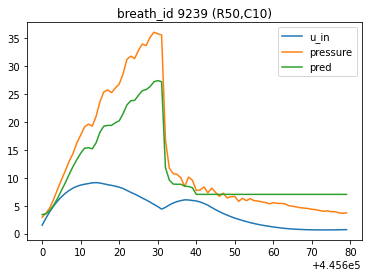

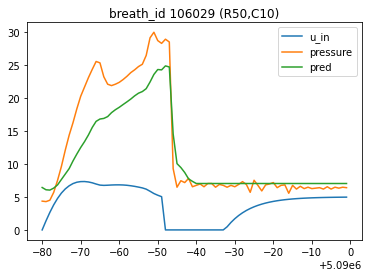

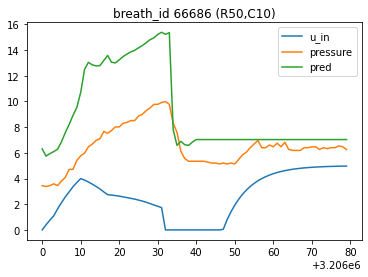

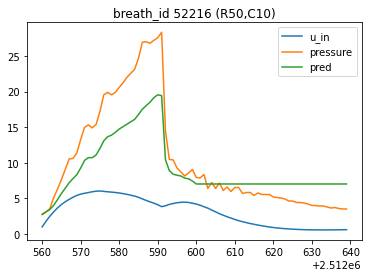

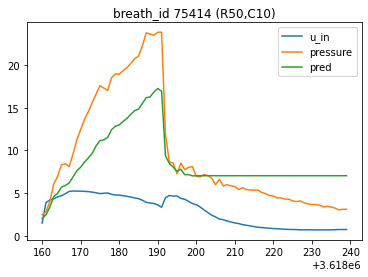

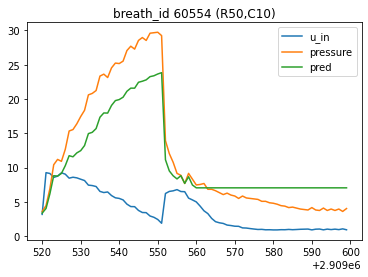

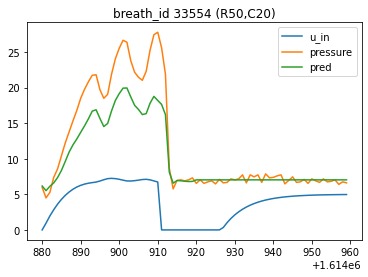

In [10]:
n_plot = 20
for i in range(n_plot):
    ev.plot_breath(breath_mae.index[i])

## 推論

In [11]:
def run_predict(model, df):
    x = make_x(df)
    pred = model.predict(x)
    return pred    

In [12]:
model = []
for fold in range(n_fold):
    with open(f"fold{fold}_model.pickle", 'rb') as p:
        mdl = pickle.load(p)
    model.append(mdl)

model = ut.EnsembleModel(model)

In [13]:
pred = run_predict(model, ts_df)
sub_df = ts_df[["id"]].copy()
sub_df["pressure"] = pred
sub_df.to_csv(f"submission_{os.path.basename(os.getcwd())}.csv", index=False)

100%|██████████| 50/50 [01:54<00:00,  2.28s/it]
